# Проект "Стримчик"

Представлены данные из открытых источников по всему миру о продажах компьютерных игр, оценок пользователей и экспертов. Необходимо выявить определяющие успешность игры закономерности для выявления потенциально популярных продуктов и планированияь рекламных кампании.

In [45]:
#Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sb

## Изучение данных

In [46]:
# Загрузка данных 
games = pd.read_csv('games.csv')
games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные отображаются верно. Опишем данные:

In [47]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Всего 16715 строк, 11 столбцов. Название столбцов нужно привести к единому стилю. 
Тип значений в столбцах : 'Year_of_Release', 'User_Score' нужно заменить.

In [48]:
games.isnull().sum()

В столбцах:
    'Name'
    'Year_of_Release'
    'Genre' 
    'Critic_Score'
    'User_Score'
    'Rating' 
есть пропуски.

In [49]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


В столбце 'JP_sales', 'Other_sales' среднее и медиана сильно отличаются, скорее всего данные смещены влево.

In [50]:
games.duplicated().sum()

0

## Подготовка данных

### Исправление названия столбцов

In [51]:
games.columns =  games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Изменение типа данных

Столбец 'year_of_release' необходимо преобразовать в int, 'user_score' - float. Оценки поьзователей - это цисла, которые потом можно анализировать суммарно. Год - целое число. 

In [52]:
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'ignore')

Для преобразования данных в столбце 'year_of_release' нужно заполнить пропуски. Например заглушкой 1900. Ее всегда можно будет отфильтровать.

In [53]:
games['year_of_release'] = games['year_of_release'].fillna('1900')
games['year_of_release'] = games['year_of_release'].astype('int') 

In [54]:
len(games[games['year_of_release'] == 1900 ])

269

In [55]:
games = games[games['year_of_release'] != 1900]
16715 - len(games)

269

In [56]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int32(1), object(5)
memory usage: 1.4+ MB


Тип данных user_score - не изменился, сначала поработаем с пропусками, а затем изменим тип данных. Тип данных year_of_release изменен.

### Заполнение пропусков

Пропуски есть в столбцах:
    'name',
    'year_of_release',
    'genre' ,
    'critic_score',
    'user_score',
    'rating'.
'Year_of_Release' - пропуски заполнены заглушкой 1900.
    

In [57]:
# Заполним пропуски в столбце с названиями игр - значением 'unknown'
games['name'] = games['name'].fillna('unknown')

In [58]:
games[games['name'] == 'unknown']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,unknown,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [59]:
games = games[games['name'] != 'unknown']
len(games)

16444

In [60]:
#Посмотрим какие жанры представлены
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [61]:
 #Заполним пропуски жанром 'others'
#games['genre'] = games['genre'].fillna('others')

In [62]:
#Посмотрим какие оценки критиков представлены
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

За критиков рассуждать мы не можем, лучше оставить пропуски.

In [63]:
#Посмотрим какие оценки пользоватлей представлены
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

'tbd' - аббревиатура, используется, если информация еще не определена.

In [64]:
games[games['user_score'] =='tbd']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Пропускам присвоим значением 'tbd'

In [65]:
#Заполним пропуски 'tbd'
games['user_score'] = games['user_score'].fillna('tbd')

Чтобы работать с user_score необходимо преобразовать в float. Заменим 'tbd' на -10. Эту заглушку можно будет отфильтровать.

In [66]:
games.loc[games['user_score'] == 'tbd', 'user_score' ] = -10
games['user_score'] = pd.to_numeric(games['user_score'] )

In [67]:
# Комментарий ревьюера 0
games[games['user_score'] == -10]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,-10.0,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,-10.0,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,-10.0,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,-10.0,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,-10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,-10.0,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,-10.0,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,-10.0,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,-10.0,NaN


In [68]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       16444 non-null  float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


Тип данных user_score изменен на float

In [69]:
#Посмотрим какие рейтинги от организации ESRB представлены
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Есть рейтинг 'RP' - рейтинг ожидается. Заполним пропуски этим значением.

In [70]:
#Заполним пропуски 'RP'
games['rating'] = games['rating'].fillna('no_ESRB')

In [71]:
# Итоговые данные
games.isnull().sum()
    

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score            0
rating                0
dtype: int64

Пропуски остались только в столбце 'critic_score'. 
Пропуски могли появиться из-за: 
1. человеческого фактора, кто-то не внес данные, пропустил ячейку, 
2. отсутсвия информации по какому-либо параметру,
3. не было единной систмы заполнения информации, вместо соотвствующего значения о том, что данные ожидаются, оставили пропуск.     

### Cуммарные продажи во всех регионах

In [72]:
games['total_sales'] =games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1) 

In [73]:
games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,-10.0,no_ESRB,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,-10.0,no_ESRB,31.38


In [74]:

games.total_sales.min()

0.0

## Исследовательский анализ данных

### Год выпуска игр

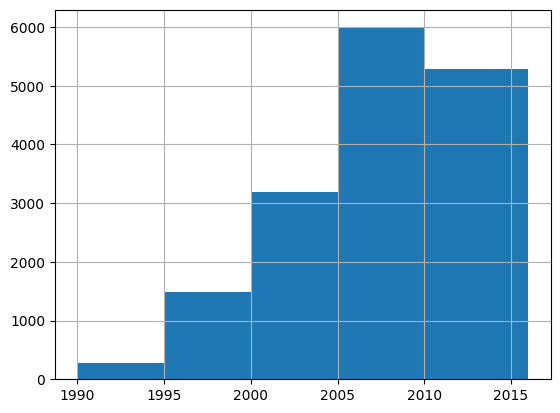

In [75]:
games['year_of_release'].hist(bins = [1990, 1995, 2000,2005,2010,2016])
plt.show()

Больше всего в данных игр, выпушенных с 2005-2016. Это логично, что с течением времени выпускается все больше и больше игр. 

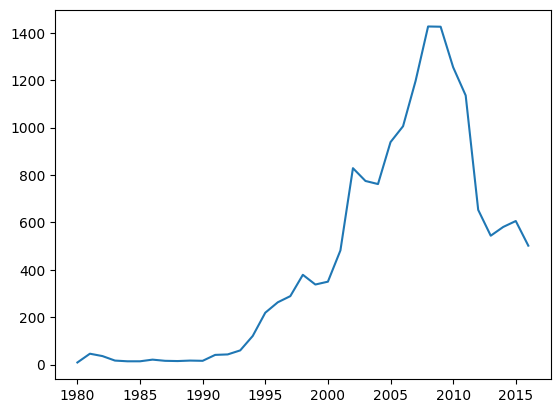

In [76]:
plt.plot(games.
         groupby('year_of_release')['name'].count())
plt.show()

Пик приходится на 2008-2009 год

Данные важны, чем больше игр в год было выпушено- тем больше конкуренция, тем больше это отражается на оценках пользователей и критиков.
Чем год выпуска больше- тем больше запросы пользователей и критиков. Игра, что получила бы максимальные оценки в 2000 году, не факт что получит их в 2022 (не считая фан базы игры). 

### Данные за актуальный период

In [77]:
games_new2 = games.query('year_of_release >2014').copy()

### Платформы - лидеры продаж

In [78]:
games_new2 = games.query('year_of_release >=2014').copy()
platform_leader2 = games_new2.groupby('platform')['total_sales'].sum().sort_values(ascending = False).head(5)
platform_leader2

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Name: total_sales, dtype: float64

PS3 уступил место XOne.

In [79]:
games_leader = games_new2.query(
    'platform in @platform_leader2.index').pivot_table(
        index ='platform',columns = 'year_of_release', values =['total_sales'], aggfunc = 'sum')
games_leader

total_sales               
year_of_release        2014    2015   2016
platform                                  
3DS                   43.76   27.78  15.14
PS3                   47.76   16.82   3.60
PS4                  100.00  118.90  69.25
X360                  34.74   11.96   1.52
XOne                  54.07   60.14  26.15

Продажи падают у всех платформ, но в разной степени. 

### График «ящик с усами» по глобальным продажам игр 

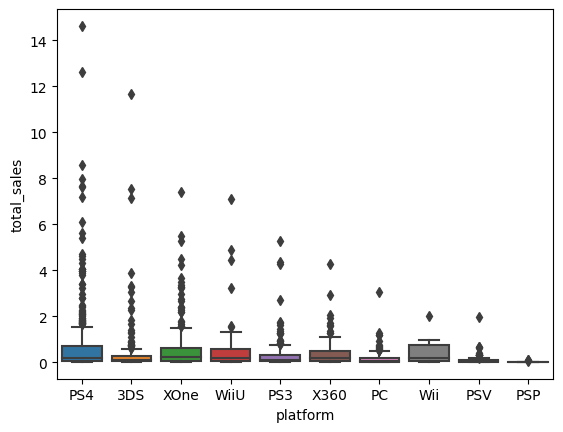

In [80]:
sb.boxplot(x =games_new2['platform'], y = games_new2['total_sales'])
plt.show()

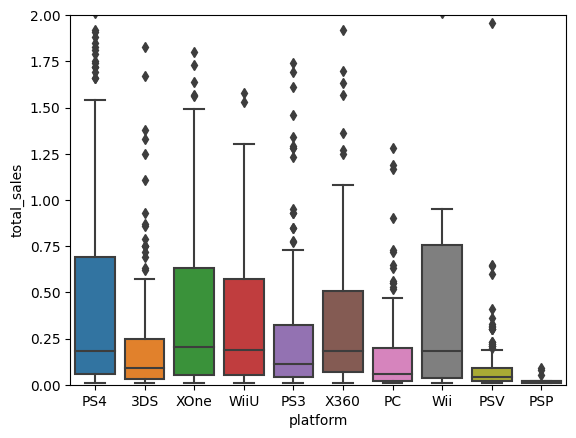

In [81]:
ax = sb.boxplot(x =games_new2['platform'], y = games_new2['total_sales'])
ax.set(ylim=(0, 2))
plt.show()

In [82]:
#опишем полученные данные
games_new2.groupby('platform')['total_sales'].describe().sort_values(by = 'mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96


Максимальные средние продажи наблюдаются у PS4. Самая большая медиана -XOne. У всех платформ много выбросов, которые влияют на среднее. Можно выделить трех лидеров - PS4,XOne, WiiU

### Влияние отзывов пользователей и критиков на продажи

Выберем одну платформу для анализа из лидеров:PS4 или XOne. ПОсчитаем общее количество записей в выборке об этой платформе (с 2014 года).

PS4 коэффициент корреляции между оценками пользователей и оценками критиков: 0.546434245119031
PS4 коэффициент корреляции между оценками пользователей и общими продажами: -0.04013158947269733
PS4 коэффициент корреляции между оценками критиков и общими продажами: 0.40190287811475284


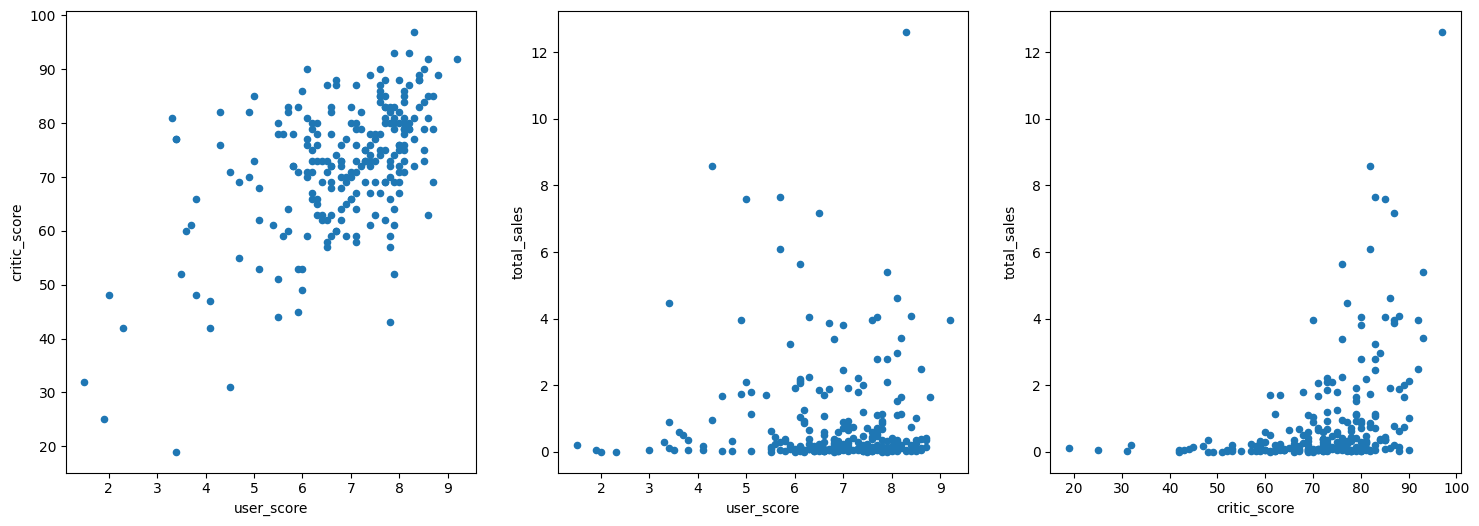

XOne коэффициент корреляции между оценками пользователей и оценками критиков: 0.44097734837644087
XOne коэффициент корреляции между оценками пользователей и общими продажами: -0.07038392806475809
XOne коэффициент корреляции между оценками критиков и общими продажами: 0.4221118510555763


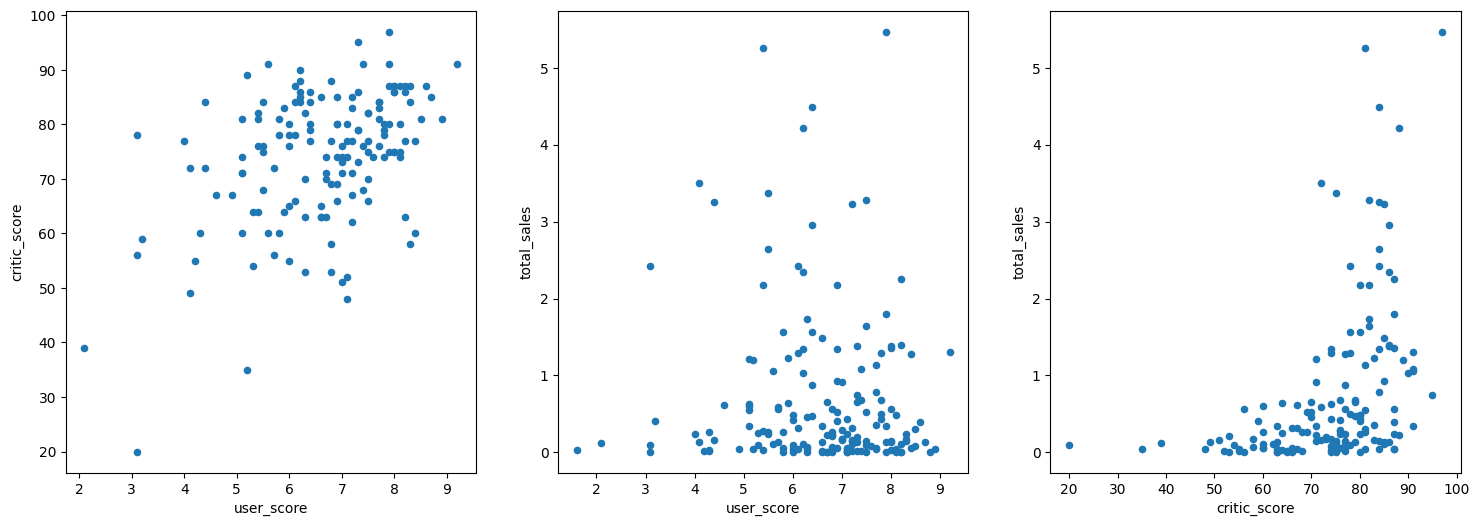

3DS коэффициент корреляции между оценками пользователей и оценками критиков: 0.862484552934546
3DS коэффициент корреляции между оценками пользователей и общими продажами: 0.2151932718527028
3DS коэффициент корреляции между оценками критиков и общими продажами: 0.28468579095782925


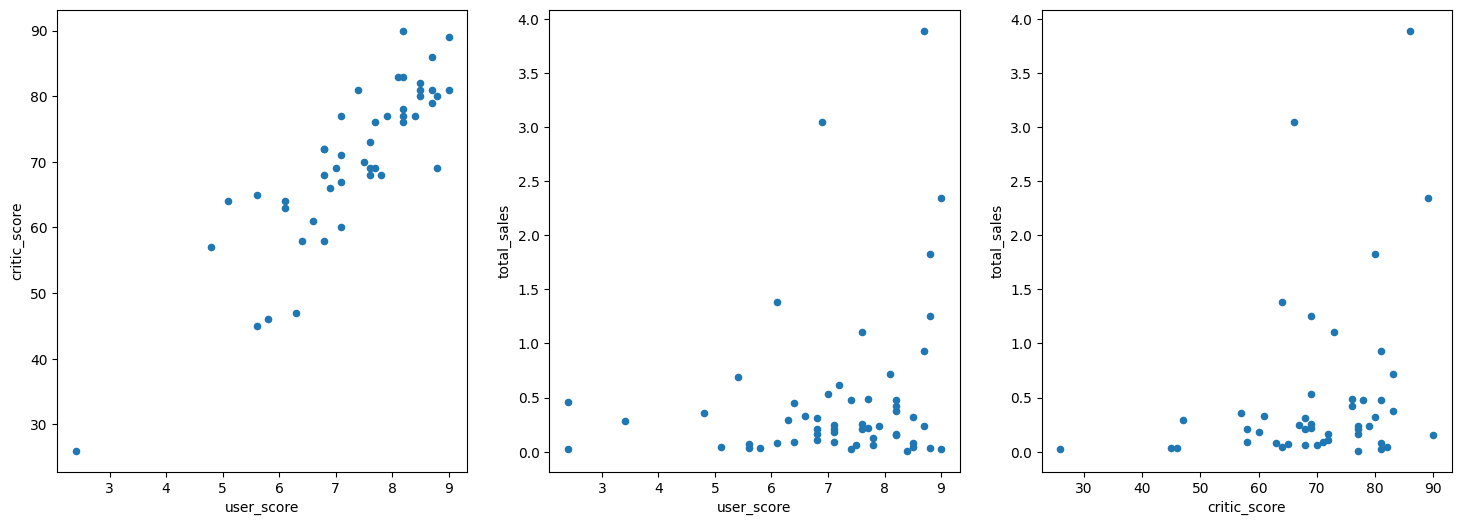

PS3 коэффициент корреляции между оценками пользователей и оценками критиков: 0.6934448406261046
PS3 коэффициент корреляции между оценками пользователей и общими продажами: -0.16676141347662118
PS3 коэффициент корреляции между оценками критиков и общими продажами: 0.44657460493190704


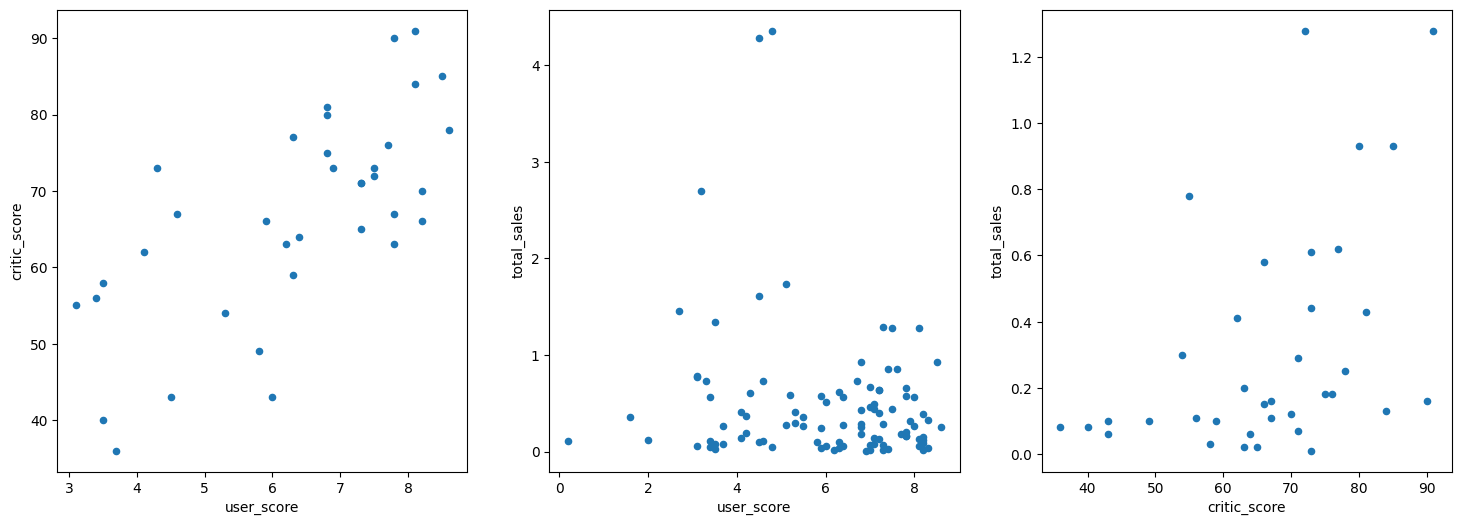

X360 коэффициент корреляции между оценками пользователей и оценками критиков: 0.6253094753809085
X360 коэффициент корреляции между оценками пользователей и общими продажами: -0.138444570945665
X360 коэффициент корреляции между оценками критиков и общими продажами: 0.5257228356581523


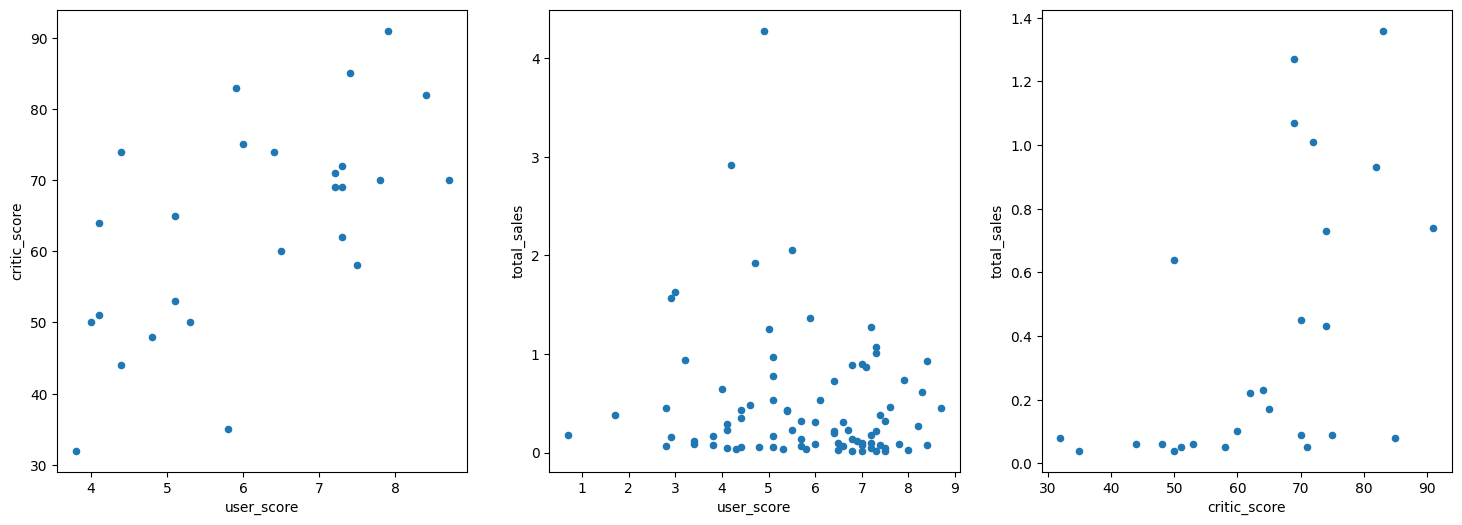

In [83]:
for platform in platform_leader2.index:
    print(platform, 'коэффициент корреляции между оценками пользователей и оценками критиков:', 
          games_new2.query('platform ==@platform and user_score>-10')['user_score'].corr(
              games_new2.query('platform ==@platform and user_score>-10')['critic_score']))
    print(platform, 'коэффициент корреляции между оценками пользователей и общими продажами:', 
          games_new2.query('platform ==@platform and user_score>-10')['user_score'].corr(
              games_new2.query('platform ==@platform and user_score>-10')['total_sales']))
    print(platform, 'коэффициент корреляции между оценками критиков и общими продажами:', 
          games_new2.query('platform ==@platform and user_score>-10')['critic_score'].corr(
              games_new2.query('platform ==@platform and user_score>-10')['total_sales']))

   

    fig, axes = plt.subplots(1, 3)
   
    games_new2.query('platform ==@platform and user_score>-10').plot(
        x = 'user_score', y = 'critic_score', kind = 'scatter', ax=axes[0])
    
    
    games_new2.query('platform ==@platform and user_score>-10').plot(
        x = 'user_score', y = 'total_sales', kind = 'scatter', ax=axes[1])
    
    
    games_new2.query('platform ==@platform and user_score>-10').plot(
        x = 'critic_score', y = 'total_sales', kind = 'scatter', ax=axes[2], figsize = (18,6))

    plt.show()
    

</font><font color='Blue'><b>Комментарий студента: 
В целом наблюдается прямая связь между оценками критиков и объемом продаж, связь между оценками пользователей и объемом продаж выявить не удалось.
</b></font><br>

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkGreen'>👌 Для оценки корреляции лучше пользоваться вот этой шкалой:</font>
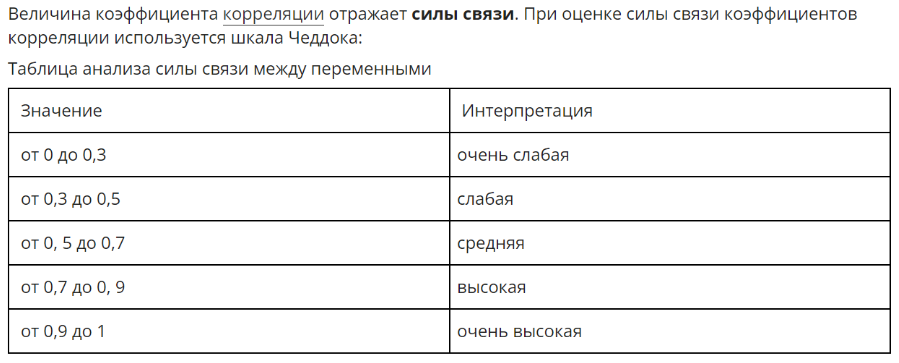

### Распределение по жанрам

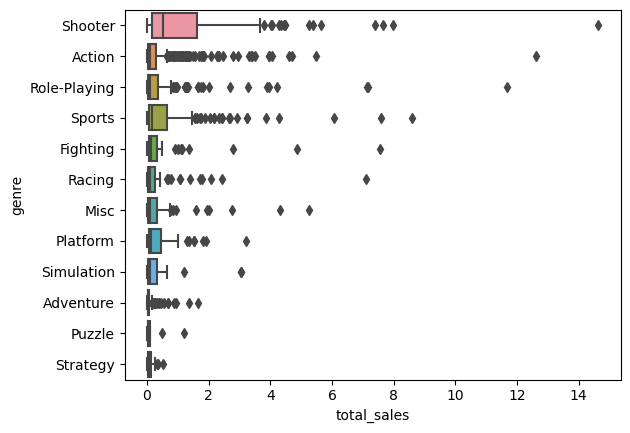

In [84]:
sb.boxplot(y =games_new2['genre'], x = games_new2['total_sales'])
plt.show()

In [85]:
#опишем полученные данные
games_new2.groupby('genre')['total_sales'].describe().sort_values(by = 'mean',ascending = False)

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Shooter,128.0,1.335469,2.050567,0.01,0.1725,0.515,1.6175,14.63
Sports,161.0,0.680000,1.239736,0.01,0.0600,0.180,0.6400,8.58
Platform,38.0,0.476053,0.722561,0.01,0.0625,0.140,0.4675,3.21
Fighting,60.0,0.470333,1.188053,0.01,0.0600,0.125,0.3200,7.55
Role-Playing,221.0,0.459005,1.177284,0.01,0.0500,0.110,0.3600,11.68
Racing,69.0,0.398841,0.963716,0.01,0.0300,0.090,0.2500,7.09
Misc,113.0,0.332301,0.736999,0.01,0.0300,0.090,0.3200,5.27
Action,619.0,0.322068,0.798181,0.01,0.0300,0.090,0.2800,12.62
Simulation,44.0,0.298409,0.646925,0.01,0.0200,0.100,0.3275,3.05


Самый прибыльный жанр- "Shooter". Самый неприбыльный - "Adventure" если опираться на среднее. Если опираться на медиану, то также непопулярны "Puzzle", "Strategy". 

## Портрет пользователя каждого региона

### Самая популярная платформа у пользователей разного региона

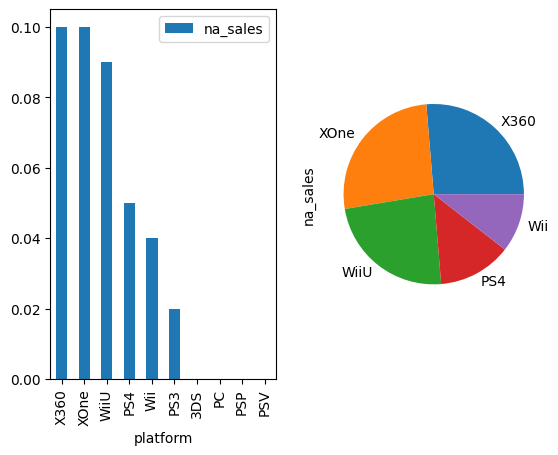

In [86]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'platform', values = 'na_sales', aggfunc = 'median').sort_values(
    by = 'na_sales', ascending = False).plot(y = 'na_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'platform', values = 'na_sales', aggfunc = 'median').sort_values(
    by = 'na_sales', ascending = False).head(5).plot(y = 'na_sales', kind = 'pie', normalize=True, ax= axes[1],legend=None)

plt.show()

В Северной Америке - популярны платформы X360, XOne. На третьем месте - WiiU.

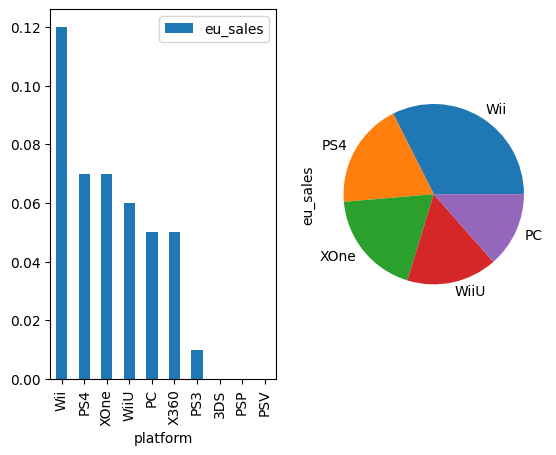

In [87]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'platform', values = 'eu_sales', aggfunc = 'median').sort_values(
    by = 'eu_sales', ascending = False).plot(y = 'eu_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'platform', values = 'eu_sales', aggfunc = 'median').sort_values(
    by = 'eu_sales', ascending = False).head(5).plot(
    y = 'eu_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

В Европе - Wii, PS4, XOne

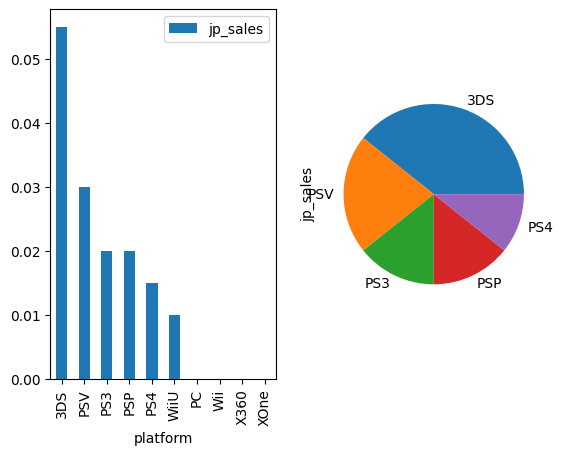

In [88]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'platform', values = 'jp_sales', aggfunc = 'median').sort_values(
    by = 'jp_sales', ascending = False).plot(
    y = 'jp_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'platform', values = 'jp_sales', aggfunc = 'median').sort_values(
    by = 'jp_sales', ascending = False).head(5).plot(
    y = 'jp_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

В Японии 3DS (которая не представлена в Северной Америке и Европе). Платформа XOne, X360 не представлены.

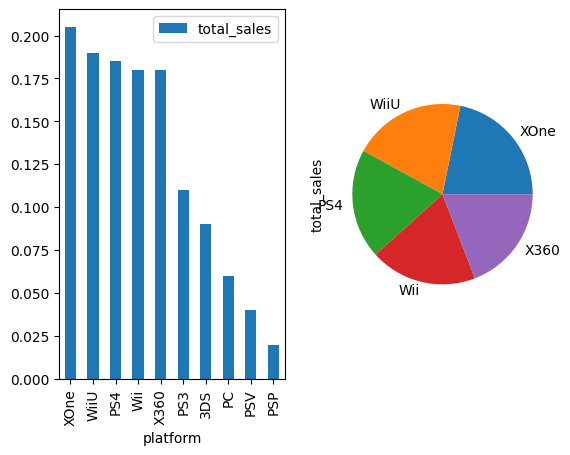

In [89]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'platform', values = 'total_sales', aggfunc = 'median').sort_values(
    by = 'total_sales', ascending = False).plot(y = 'total_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'platform', values = 'total_sales', aggfunc = 'median').sort_values(
    by = 'total_sales', ascending = False).head(5).plot(
    y = 'total_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

В среднем среди пользователей лидирует XOne. Но максимальные продажи в сумме приносит платформа PS4. 

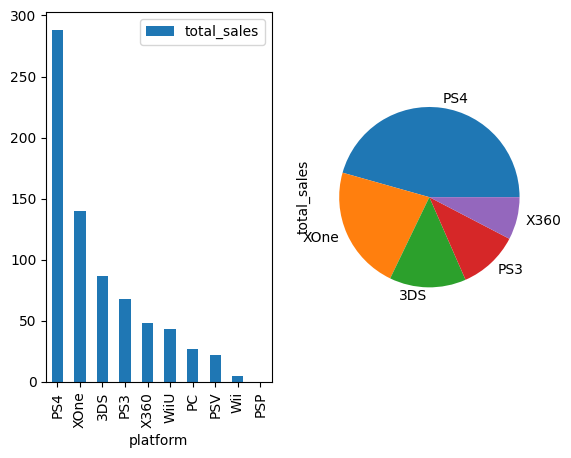

In [90]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(
    by = 'total_sales', ascending = False).plot(y = 'total_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(
    by = 'total_sales', ascending = False).head(5).plot(
    y = 'total_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

### Самый популярный жанр у пользователей разного региона

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'genre', values = 'na_sales', aggfunc = 'median').sort_values(
    by = 'na_sales', ascending = False).plot(y = 'na_sales', kind = 'bar',ax= axes[0])
games_new2.pivot_table(
    index = 'genre', values = 'na_sales', aggfunc = 'median').sort_values(
    by = 'na_sales', ascending = False).head(5).plot(
    y = 'na_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )

plt.show()

Самый популярный жанр в Северной Америке - Shooter

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'genre', values = 'eu_sales', aggfunc = 'median').sort_values(
    by = 'eu_sales', ascending = False).plot(y = 'eu_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'genre', values = 'eu_sales', aggfunc = 'median').sort_values(
    by = 'eu_sales', ascending = False).head(5).plot(
    y = 'eu_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

Самый популярный жанр в Европе - Shooter

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'genre', values = 'jp_sales', aggfunc = 'median').sort_values(
    by = 'jp_sales', ascending = False).plot(y = 'jp_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'genre', values = 'jp_sales', aggfunc = 'median').sort_values(
    by = 'jp_sales', ascending = False).head(5).plot(
    y = 'jp_sales', kind = 'pie', normalize=True , ax= axes[1],legend=None )
plt.show()

Самый популярный жанр в Японии - Role-Playing.

В Японии представлен ограничиный набор жанров.

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'rating', values = 'na_sales', aggfunc = 'median').sort_values(
    by = 'na_sales', ascending = False).plot(y = 'na_sales', kind = 'bar',ax= axes[0])
games_new2.pivot_table(
    index = 'rating', values = 'na_sales', aggfunc = 'sum').plot(
    y = 'na_sales', kind = 'bar',  ax= axes[1],legend=None )
plt.show()

Самый популярный рейтинг в Северной Америке - М

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'rating', values = 'eu_sales', aggfunc = 'median').sort_values(
    by = 'eu_sales', ascending = False).plot(y = 'eu_sales', kind = 'bar',ax= axes[0])
games_new2.pivot_table(
    index = 'rating', values = 'eu_sales', aggfunc = 'sum').plot(
    y = 'eu_sales', kind = 'bar',  ax= axes[1],legend=None )
plt.show()

Самый популярный рейтинг в Европе - М

In [ ]:
fig, axes = plt.subplots(1, 2)
games_new2.pivot_table(
    index = 'rating', values = 'jp_sales', aggfunc = 'median').sort_values(
    by = 'jp_sales', ascending = False).plot(y = 'jp_sales', kind = 'bar', ax= axes[0])
games_new2.pivot_table(
    index = 'rating', values = 'jp_sales', aggfunc = 'sum').plot(
    y = 'jp_sales', kind = 'bar',  ax= axes[1],legend=None )
plt.show()

Самый популярный рейтинг в Японии -no_ESRB, игры, оцененные по этой системе, малопопулярны в этом регионе.

Данные для Северной Америки и Европы - схожи.  Для Японии портерт пользователя совершенно инной, так они используют платформу 3DS, которая не представлена в других регионах, предпочитают жанр Role-Playing, малопопулярный в Европе и Северной Америке 

## Гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H_0: Средние пользовательские рейтинги платформ XOne и PS4 одинаковые`

H_a: Средние пользовательские рейтинги платформ XOne и PS4 неодинаковые`

alpha = 0.05

In [ ]:
data = games_new2.query('user_score>-10')
results = st.ttest_ind(
    data[data['platform'] =='XOne']['user_score'],
    data[data['platform'] =='PS4']['user_score'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue <alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
# Комментарий ревьюера
data[data['platform'] =='XOne']['user_score'].min(), data[data['platform'] =='PS4']['user_score'].min()

In [ ]:
 data.groupby('platform')['user_score'].describe().sort_values(by = 'mean', ascending = False)

### Средние пользовательские рейтинги жанров Action  и Sports  разные.

H_0: С Средние пользовательские рейтинги жанров Action  и Sports  одинаковые`

H_a:  Средние пользовательские рейтинги жанров Action  и Sports  разные

alpha = 0.05

In [ ]:
results = st.ttest_ind(
    data[data['genre'] =='Action']['user_score'],
    data[data['genre'] =='Sports']['user_score'], equal_var = False)

alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue <alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

In [ ]:
# Комментарий ревьюера 4
data.year_of_release.min()

Нулевая гипотеза - гипотеза о равнестве средний значений, альтернативная - они неравны. Применялся двухстороний критерий. Критерий значимости выбран как 0.05

In [ ]:
data.groupby('genre')['user_score'].describe().sort_values(by = 'mean', ascending = False)

## Вывод

Были проанализированы данные из открытых источников по всему миру о продажах компьютерных игр, оценок пользователей и экспертов с целью выявить определяющие успешность игры закономерности. Данный анализ поможет выявить потенциально популярные продукты и спланировать рекламные кампании.

Всего 16715 строк, 11 столбцов. 

<b> Задачи исследования:</b>
1. Провести предобработку данных. Заполнить пропуски, изменить тип данных в столбцах на соответствующий.  
2. Провести исследовательский анализ данных:
  - определить на что влияет год выпуска игры
  - определить какой период из данных стоит проанализировать
  - определить платформы лидеры-продаж
  - проанализировать глобальные продажи игр в разбивке по платформам
  - выяснить степень влияние отзывов пользователей и экспертов на уровень продаж
  - оценить прибыльность жанров
3. Составьте портрет пользователя каждого региона
  -  определить самые популярные платформы
  - определить самые популярные жанры
  - оценить влияние рейтинга ESRB на продажи
4. Проверьте гипотезы
  - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
  - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

<b>Задача 1. Предобработка данных.</b>
Были приведены названия столбцов к единому формату.

Тип данных "user_score" приведен к формату float, "year_of_release" - к целочисленному формату.

Строки с пропуском в столбце 'name', "genre" - удалены (2 строки).
Строки с пропусками в столбце year_of_release"  - удалены (269 строк).
В столбце "critic_score" - пропуски остались, "user_score" - выяснилось, что значения tbd маркируют игры ожидающие оценки, таким образом пропуски заполнены сначала tbd, а затем для добства работы с данными заглушкой -10, "rating" - "no_ESRN", как не отмеченные данной системой оценок.

При анализе данных заглушки всегда можно отфильтровать. 

<b>Задача 2. Исследовательский анализ данных.</b>
Пик продаж игр приходится на 2008-2009 год по имеющимся данным. 

Чем год выпуска больше- тем больше запросы пользователей и критиков. Игра, что получила бы максимальные оценки в 2000 году, не факт, что получит их в 2022 (не считая фан базы игры). Поэтому для дальнейшего анализа было принято решения оставить только игры, выпушенные с 2014 года.

Были определены лидеры продаж среди платформ:
       Данные о общей сумме продаж с 2014-2016 год
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
Однако в последние три года у всех компаний наблюдается снижение общей суммы продаж, но в разной степени.

Максимальные средние продажи наблюдаются у PS4. У всех платформ много выбросов, которые влияют на среднее. Однако, можно выделить двух лидеров - PS4,XOne, WiiU.

Выяснено, что слабая положительная корреляция наблюдается между отзывами критиков и объемами продаж. Так,
PS4 коэффициент корреляции: 0.40
XOne коэффициент корреляции: 0.42
3DS коэффициент корреляции: 0.29
PS3 коэффициент корреляции: 0.45
X360 коэффициент корреляции: 0.53

Самый прибыльный жанр- "Shooter". Самый неприбыльный - "Adventure" если опираться на среднее. Если опираться на медиану, то также непопулярны "Puzzle", "Strategy".  

<b>Задача 3. Портрет пользователя каждого региона.</b>

Данные для Северной Америки и Европы - схожи. 
Самые популярные платформы для Северной Америки X360,XOne, WiiU, PS4, Wii.
Самые популярные платформы для Европы Wii,PS4, XOne, WiiU, PC.

Для Японии : 3DS, PSV, PS3, PSP, PS4.


Самые популярные жанры для Северной Америки: Shooter, Platform, Sports, Fighting, Racing.
Самые популярные жанры для Европы: Shooter, Platform,Racing, Sports, Simulation. 
Для Японии : Role-playing, Fighting, Puzzle, Action, Adventure.




PS4 и XOne, жанр -Shooter, рейтинг - М.

Для Японии самая популярная платформа - 3DS, жанр - Role-playing, и отсутсвие рейтинга ESRB.

<b>Задача 4. Гипотезы.</b>

Нулевая гипотеза о том, что средние пользовательские рейтинги платформ XOne и PS4 одинаковые- не отвергнута.
Нулевая гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports одинаковые - отвергнута.

<b>Вывод:</b>по данным самой популярной платформой является PS4 и XOne.
Жанр Shooter - считается наиболее прибыльным и популярным. При прогнозе успешности игры следуют больше уделять внимание оценкам критиков, чем пользователей. Для Японии нужно опираться на другие данные: самая популярная платформа - 3DS, жанр - Role-playing, и отсутсвие рейтинга ESRB.

